# Spectral Domain Noise Attenuation Steps

**Note:** The images displayed is of authors own collected fingerprint and hence is released here.

## Defining Functions

In [1]:
import os
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.metrics import structural_similarity as ssim
from skimage.feature import match_template
import fingerprint_enhancer
from skimage.util import invert
from PIL import Image
from scipy.fft import fftfreq, fft, ifft, fftshift, ifftshift, fft2, ifft2

In [2]:
CROP_Y = 3000
FS = 1050
DELTA = 10

In [ ]:
# Function to crop image
def ToCrop(img):
    img = img[0:CROP_Y, 0:]
    h, w = img.shape[:2]
    img = cv2.resize(img, (w // 3, h // 3))
    return img

# Function to convert image to grayscale
def ToGray(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray

# Function to apply CLAHE
def ToCLAHE(img):
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8, 8))
    cl = clahe.apply(img)
    return cl

# Function to apply Gaussian blur
def ToBlur(img):
    blur = cv2.GaussianBlur(img, (15, 15), 0)
    return blur

# Function to binarize image
def ToBinary(img):
    binary = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 29, 2)
    kernel = np.ones((2, 2), np.uint8)
    binary = cv2.dilate(binary, kernel, iterations=2)
    binary = cv2.erode(binary, kernel, iterations=2)
    return binary

# Function to apply Gabor filter
def ToGabor(img):
    enh = fingerprint_enhancer.enhance_fingerprint(img)
    if enh.dtype == bool:
        enh = enh.astype(np.uint8) * 255
    kernel = np.ones((2, 2), np.uint8)
    enh = cv2.dilate(enh, kernel, iterations=2)
    enh = cv2.erode(enh, kernel, iterations=2)
    return enh

# Function to get correlation
def GetCorr(img1, img2):
    if img1.ndim == 3:
        img1 = ToGray(img1)
    if img2.ndim == 3:
        img2 = ToGray(img2)
    img1 = np.float32(img1)
    img2 = np.float32(img2)
    shift, response = cv2.phaseCorrelate(img1, img2)
    return shift

# Function to segment image based on R/G ratio
def ToSegmentRG(image, thresh=1.1):
    red_channel = image[:, :, 0]
    green_channel = image[:, :, 1]
    epsilon = 1e-6
    rg_ratio = red_channel / (green_channel + epsilon)
    thresh = 1.1
    binary_mask = rg_ratio < thresh
    binary_mask = binary_mask.astype(np.uint8) * 255
    return binary_mask

# Function to get background segmentation
def getBGSeg(img, thresh=1.1):
    seg = ToSegmentRG(img, thresh)
    return seg

# Function to align images
def getFineAlign(image, image_f):
    def alignBlur(img):
        img_blur = cv2.GaussianBlur(img, (31, 31), 0)
        return img_blur

    apply_transform = transforms.Compose([
        transforms.Lambda(lambda x: np.array(x)),
        transforms.Lambda(lambda x: ToGray(x)),
        transforms.Lambda(lambda x: ToCLAHE(x)),
        transforms.Lambda(lambda x: alignBlur(x)),
        transforms.Lambda(lambda x: ToBinary(x)),
    ])

    bin_image = apply_transform(image)
    bin_image_f = apply_transform(image_f)

    shift, _ = cv2.phaseCorrelate(np.float32(bin_image), np.float32(bin_image_f))
    dx, dy = shift
    translation_matrix = np.array([
        [1, 0, -dx],
        [0, 1, -dy]
    ], dtype=np.float32)
    height, width = image_f.shape[:2]

    aligned_img_corr = cv2.warpAffine(image_f, translation_matrix, (width, height))

    if dx > 0:  
        crop_x_start = 0
        crop_x_end = width - int(dx)

    elif dx < 0:  
        crop_x_start = -int(dx)
        crop_x_end = width

    else:
        crop_x_start = 0
        crop_x_end = width

    if dy > 0:  
        crop_y_start = 0
        crop_y_end = height - int(dy)

    elif dy < 0:  
        crop_y_start = -int(dy)
        crop_y_end = height

    else:
        crop_y_start = 0
        crop_y_end = height

    image = image[crop_y_start:crop_y_end, crop_x_start:crop_x_end]
    aligned_img_corr = aligned_img_corr[crop_y_start:crop_y_end, crop_x_start:crop_x_end]

    return image, aligned_img_corr, crop_y_start, crop_y_end, crop_x_start, crop_x_end

# Function to clear background
def ClearBG(image, aligned_img_corr, thresh=1.1):
    seg = getBGSeg(image, thresh)
    modified_image = image.copy()
    modified_image_f = aligned_img_corr.copy()
    modified_image[seg == 255] = 255
    modified_image_f[seg == 255] = 255
    return modified_image, modified_image_f

# Function to apply low pass filter
def low_pass_filter_image(grayscale_image, cutoff_freq, fs):
    image_data = grayscale_image.astype(float) / 255
    fft_image = fft(image_data)
    rows, cols = image_data.shape
    f_x, f_y = fftfreq(cols), fftfreq(rows)
    nyquist_x = 0.5 * fs / cols
    nyquist_y = 0.5 * fs / rows
    cutoff_radius = min(cutoff_freq / nyquist_x, cutoff_freq / nyquist_y)
    mask = np.zeros_like(fft_image)
    center_x, center_y = cols // 2, rows // 2
    mask[center_y - int(cutoff_radius * rows):center_y + int(cutoff_radius * rows + 1),
         center_x - int(cutoff_radius * cols):center_x + int(cutoff_radius * cols + 1)] = 1
    filtered_fft = fft_image * mask
    filtered_image = np.real(ifft(filtered_fft))
    filtered_image = (filtered_image * 255).astype(np.uint8)
    return filtered_image

# Function to find optimal cutoff frequency
def find_optimal_cutoff(channel, fs): 
    fft_image = fftshift(fft2(channel))
    magnitude_spectrum = np.abs(fft_image)
    rows, cols = channel.shape
    center_x, center_y = cols // 2, rows // 2
    Y, X = np.ogrid[:rows, :cols]
    distance_from_center = np.sqrt((X - center_x)**2 + (Y - center_y)**2)
    radial_profile = np.bincount(distance_from_center.ravel().astype(int),
                                 weights=magnitude_spectrum.ravel()) / np.bincount(distance_from_center.ravel().astype(int))
    threshold = 0.5 * np.max(radial_profile)
    below_threshold_indices = np.where(radial_profile < threshold)[0]
    if len(below_threshold_indices) == 0:
        return fs / 4
    optimal_cutoff = below_threshold_indices[0] * (fs / max(rows, cols))
    return optimal_cutoff

# Function to perform subtraction
def Subtraction(modified_image, modified_image_f, fs_inp, delta):
    modified_image_r = modified_image[:, :, 0]
    modified_image_f_r = modified_image_f[:, :, 0]
    modified_image_g = modified_image[:, :, 1]
    modified_image_f_g = modified_image_f[:, :, 1]
    modified_image_b = modified_image[:, :, 2]
    modified_image_f_b = modified_image_f[:, :, 2]

    cutoff_r = find_optimal_cutoff(modified_image_r, fs_inp)
    cutoff_g = find_optimal_cutoff(modified_image_g, fs_inp)
    cutoff_b = find_optimal_cutoff(modified_image_b, fs_inp)
    cutoff = (cutoff_r + cutoff_g + cutoff_b) / 3.0

    alpha = 1
    fs = max(modified_image.shape[0], modified_image.shape[1]) + delta

    modified_image_r_low = low_pass_filter_image(modified_image_r, cutoff, fs)
    modified_image_g_low = low_pass_filter_image(modified_image_g, cutoff, fs)
    modified_image_b_low = low_pass_filter_image(modified_image_b, cutoff, fs)

    diff_r = modified_image_f_r - (modified_image_r_low) * alpha
    diff_g = modified_image_f_g - (modified_image_g_low) * alpha
    diff_b = modified_image_f_b - (modified_image_b_low) * alpha

    A = cv2.merge([modified_image_f_r, modified_image_f_g, modified_image_f_b])
    B = cv2.merge([modified_image_r, modified_image_g, modified_image_b])
    ret2 = cv2.merge([diff_r, diff_g, diff_b])

    return A, B, ret2

def BinarizeSub(modified_image, modified_image_f, diff_image):

    apply_transform = transforms.Compose([
        transforms.Lambda(lambda x: np.array(x)),
        transforms.Lambda(lambda x: ToGray(x)),
        transforms.Lambda(lambda x: ToCLAHE(x)),
        transforms.Lambda(lambda x: ToBinary(x)),
        transforms.Lambda(lambda x: ToBlur(x)),
        transforms.Lambda(lambda x: ToGabor(x)),
    ])

    transform_modified_image = apply_transform(modified_image)
    transform_modified_image_f = apply_transform(modified_image_f)
    transform_diff_image = apply_transform(diff_image)

    return transform_modified_image, transform_modified_image_f, transform_diff_image

## Load Data

In [ ]:
s1_dir = "<DIRNAME>"
s2_dir = "<DIRNAME>"

In [15]:
class SortedImageFolder(torchvision.datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super(SortedImageFolder, self).__init__(root, transform)
        self.samples = sorted(self.samples, key=lambda x: int(x[0].split('/')[-2].replace('P', '')))

def get_dataloader(data_dir, batch_size):
    dataset = SortedImageFolder(root=data_dir, transform=transforms.Compose([
        transforms.Lambda(lambda x: np.array(x)),
        transforms.Lambda(lambda x: ToCrop(x)),
    ]))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

data_loader = get_dataloader(s1_dir,1)

def final_edge_align(data_loader):
    i = 0
    new_dataset = []
    while i < 40: # just downloding sample of images
        image, label = data_loader.dataset[i]
        image_f, label_f = data_loader.dataset[i+5]
        h, w = image.shape[:2]
        new_dataset.append((image, label))
        new_dataset.append((image_f, label_f))
        if (i+1) % 5 == 0:
            i+=6
        else:
            i+=1
    return new_dataset

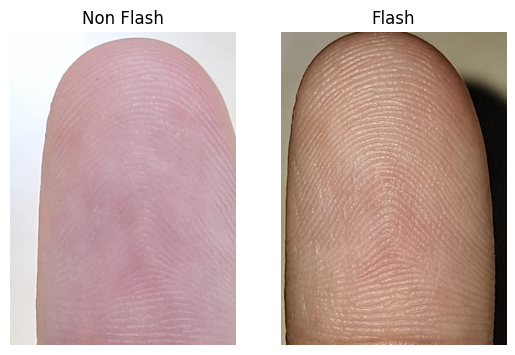

In [27]:
image1, _ = data_loader.dataset[11] # 14
image1_f, _ = data_loader.dataset[16] # 15

plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.axis("off")
plt.title("Non Flash")
plt.subplot(1, 2, 2)
plt.imshow(image1_f)
plt.axis("off")
plt.title("Flash")
# plt.savefig("1_eg2.png", dpi=500, bbox_inches="tight")
plt.show()

In [28]:
new_dataset = final_edge_align(data_loader)

apply_transform = transforms.Compose([
    transforms.Lambda(lambda x: np.array(x)),
])

new_dataset_t = [(apply_transform(x), y) for x, y in new_dataset]
aligned_data_loader = DataLoader(new_dataset_t, batch_size=1, shuffle=False)

### 1. ROI Selection and Pixel Alignment

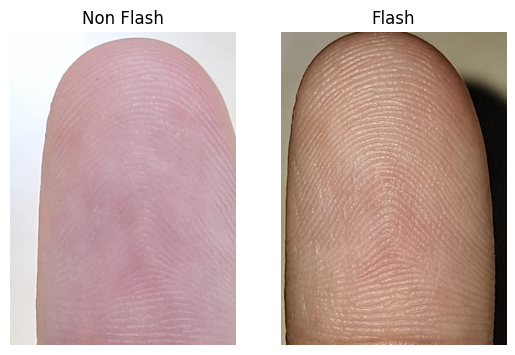

In [30]:
image1, _ = aligned_data_loader.dataset[12] 
image1_f, _ = aligned_data_loader.dataset[13] 

plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.axis("off")
plt.title("Non Flash")
plt.subplot(1, 2, 2)
plt.imshow(image1_f)
plt.axis("off")
plt.title("Flash")
# plt.savefig("2_eg2.png", dpi=500, bbox_inches="tight")
plt.show()

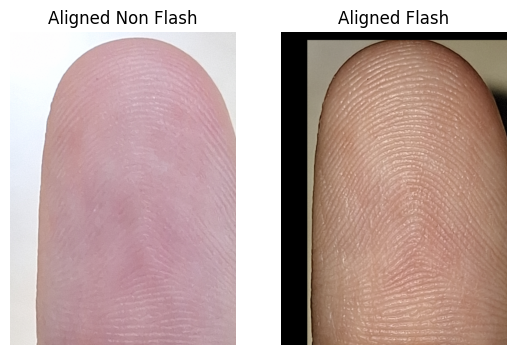

In [31]:
image1, aligned_img_corr1, crop_y_start,  crop_y_end, crop_x_start, crop_x_end = getFineAlign(image1, image1_f)

plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.axis("off")
plt.title("Aligned Non Flash")
plt.subplot(1, 2, 2)
plt.imshow(aligned_img_corr1)
plt.axis("off")
plt.title("Aligned Flash")
# plt.savefig("32_eg1.png", dpi=500, bbox_inches="tight")
plt.show()

### 2. Finger Segmentation and Background Removal

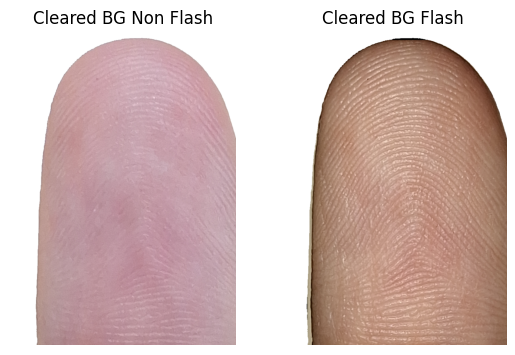

In [32]:
modified_image1, modified_image_f1 = ClearBG(image1, aligned_img_corr1)

plt.subplot(1, 2, 1)
plt.imshow(modified_image1)
plt.axis("off")
plt.title("Cleared BG Non Flash")
plt.subplot(1, 2, 2)
plt.imshow(modified_image_f1)
plt.axis("off")
plt.title("Cleared BG Flash")
# plt.savefig("4_eg2.png", dpi=500, bbox_inches="tight")
plt.show()

### 3. Subtraction

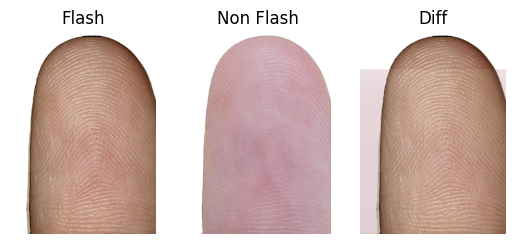

In [33]:
diff_image11, diff_image13, diff_image12  = Subtraction(modified_image1, modified_image_f1, 930, DELTA+10)

plt.subplot(1, 3, 1)
plt.imshow(diff_image11)
plt.axis("off")
plt.title("Flash")
plt.subplot(1, 3, 2)
plt.imshow(diff_image13)
plt.axis("off")
plt.title("Non Flash")
plt.subplot(1, 3, 3)
plt.imshow(diff_image12)
plt.axis("off")
plt.title("Diff")
# plt.savefig("5_eg2.png", dpi=500, bbox_inches="tight")
plt.show()

### 4. Post Processing

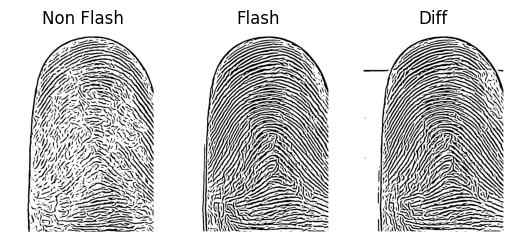

In [34]:
transform_modified_image, transform_modified_image_f, transform_diff_image11 = BinarizeSub(modified_image1, modified_image_f1, diff_image12)
transform_modified_image   = 1.0 - transform_modified_image
transform_modified_image_f = 1.0 - transform_modified_image_f
transform_diff_image11     = 1.0 - transform_diff_image11

plt.subplot(1, 3, 1)
plt.imshow(transform_modified_image, cmap='gray')
plt.axis("off")
plt.title("Non Flash")
plt.subplot(1, 3, 2)
plt.imshow(transform_modified_image_f, cmap='gray')
plt.axis("off")
plt.title("Flash")
plt.subplot(1, 3, 3)
plt.imshow(transform_diff_image11, cmap='gray')
plt.axis("off")
plt.title("Diff")
# plt.savefig("6_eg1.png", dpi=500, bbox_inches="tight")
plt.show()